In [1]:
import numpy as np
import fitsio
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
import os
import tqdm
import scipy.optimize
import healpy as hp
# sys.path.append('/home/zhuoqizhang/miniconda3/envs/shearDM/lib/python3.10/site-packages/')
import pymaster as nmt

In [2]:
# load data from DES
e1, e2, ra, dec, weight = np.load('/project2/chihway/dhayaa/DES_Catalogs/For_Jackie.npy')

In [3]:
nside = 1024
npix = hp.nside2npix(nside)
map_counts = np.zeros(npix)
map_e1 = np.zeros(npix)
map_e2 = np.zeros(npix)
pix = hp.ang2pix(nside, ra, dec, lonlat=True)
ind, counts = np.unique(pix, return_counts=True)
map_counts[ind] += counts
# Note that we set response to 1. This shouldn't change the relative amplitude of C_ell
map_e1 += np.bincount(pix,e1*weight,minlength=npix)/map_counts
map_e2 += np.bincount(pix,e2*weight,minlength=npix)/map_counts
map_e1[np.isnan(map_e1)] = 0
map_e2[np.isnan(map_e2)] = 0
mask = map_counts!=0

/tmp/ipykernel_8976/2538403141.py:10: RuntimeWarning: invalid value encountered in divide
  map_e1 += np.bincount(pix,e1*weight,minlength=npix)/map_counts
/tmp/ipykernel_8976/2538403141.py:11: RuntimeWarning: invalid value encountered in divide
  map_e2 += np.bincount(pix,e2*weight,minlength=npix)/map_counts


In [4]:
edge = (np.linspace(np.sqrt(8), np.sqrt(2048), 33)**2).astype(np.int_)
b = nmt.NmtBin.from_edges(edge[:-1],edge[1:])
ell_eff = b.get_effective_ells()

In [5]:
f2 = nmt.NmtField(mask, [map_e1, -map_e2])

In [6]:
w = nmt.NmtWorkspace()
w.compute_coupling_matrix(f2, f2, b)

In [7]:
cl_coupled = nmt.compute_coupled_cell(f2, f2)
cl_decoupled = w.decouple_cell(cl_coupled)

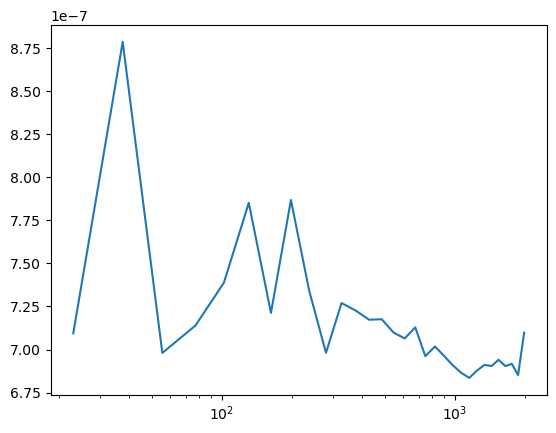

In [8]:
plt.plot(ell_eff[1:], cl_decoupled[3][1:])
plt.xscale('log')

### Random rotation

In [9]:
def rotate_ellipticities(e1, e2, rot_angle):
        """
        Random rotate ellipticities e1 and e2 over
        angles given in `rot_angle`, which is in
        units of radians
        """

        #Rotate galaxy shapes randomly
        cos = np.cos(rot_angle)
        sin = np.sin(rot_angle)

        e1 = + e1 * cos + e2 * sin
        e2 = - e1 * sin + e2 * cos

        return e1, e2

In [10]:
nside = 1024 # 3 arcmin pixels
masklen = np.sum(mask)
rand_map_e1 = np.zeros(masklen)
rand_map_e2 = np.zeros(masklen)


pix = hp.ang2pix(nside, ra, dec, lonlat=True)
for j in tqdm.trange(0, 50): 
    rot_angle = np.random.default_rng(j).random(e1.size)*2*np.pi
    e1_rot, e2_rot = rotate_ellipticities(e1, e2, rot_angle)
    rand_map_e1 = np.bincount(pix,e1_rot*weight,minlength=npix)[mask]/map_counts[mask]
    rand_map_e2 = np.bincount(pix,e2_rot*weight,minlength=npix)[mask]/map_counts[mask]
    np.save(f'/project2/chihway/jackie/decade/Bmode-DES/rand_map_weighted_e1_{j}.npy',rand_map_e1)
    np.save(f'/project2/chihway/jackie/decade/Bmode-DES/rand_map_weighted_e2_{j}.npy',rand_map_e2)

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [15:35<00:00, 18.70s/it]


In [11]:
BB_rand = []
for j in tqdm.trange(0,50):
    rand_e1 = np.zeros(npix)
    rand_e2 = np.zeros(npix)
    rand_e1[mask] = np.load(f'/project2/chihway/jackie/decade/Bmode-DES/rand_map_weighted_e1_{j}.npy')
    rand_e2[mask] = np.load(f'/project2/chihway/jackie/decade/Bmode-DES/rand_map_weighted_e2_{j}.npy')
    frand = nmt.NmtField(mask, [rand_e1, -rand_e2])
    BB_rand.append(w.decouple_cell(nmt.compute_coupled_cell(frand, frand)))
BB_rand = np.array(BB_rand)

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [07:59<00:00,  9.59s/it]


Text(0, 0.5, '$\\ell\\times C_\\ell^{BB}$')

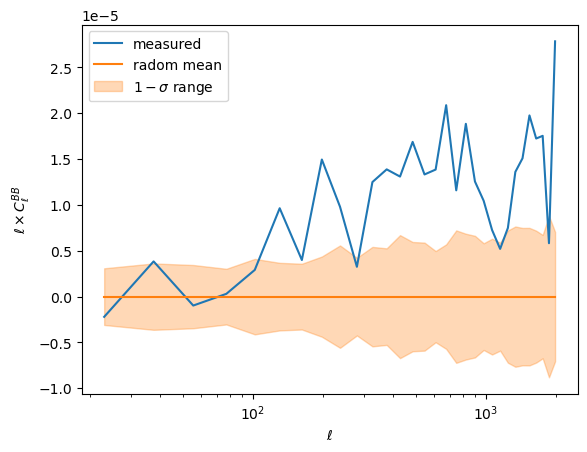

In [24]:
mean = np.mean(BB_rand[:,3,1:],axis=0)
std = np.std(BB_rand[:,3,1:],axis=0)
plt.plot(ell_eff[1:], ell_eff[1:]*(cl_decoupled[3][1:]-mean),label='measured')
plt.plot(ell_eff[1:], 0*mean, color='tab:orange',label='radom mean')
plt.fill_between(ell_eff[1:],0-ell_eff[1:]*std,0+ell_eff[1:]*std,color='tab:orange',alpha=0.3,label=r'$1-\sigma$ range')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell\times C_\ell^{BB}$')